Periodontitis Detection: Proof of Concept

This notebook serves as an initial proof of concept for detecting periodontitis using image enhancement, tooth segmentation, and bone loss measurement.

1. Preprocessing – Apply K-CFDO image enhancement to improve the clarity of the X-ray.
2. Tooth Segmentation – Use YOLOv8 to segment individual teeth in the image.
3. CEJ and Alveolar Bone Crest Segmentation – Use U-Net to segment the CEJ and alveolar bone crest for bone loss measurement.
4. Bone Loss Measurement – Calculate the CEJ-to-bone crest distance in pixels and convert it to millimeters using a scaling factor.
5. Periodontitis Detection – Classify teeth based on bone loss severity (≥ 2 mm for periodontitis).


In [28]:
# 1. Preprocessing – Apply K-CFDO image enhancement.
"""
K-CFDO (Kernel-based Contrast and Feature Detail Optimization) Image Enhancement

Parameters:
-----------
ρ (rho): A regularization parameter in the range [0,1] that controls the balance between
         noise reduction and detail preservation. Lower values preserve more details but may
         retain more noise, while higher values reduce noise but might blur fine details.
         - When ρ approaches 0: Emphasizes detail preservation
         - When ρ approaches 1: Emphasizes noise reduction

k: A scaling factor that adjusts the strength of the kernel filter. It controls the 
   emphasis on image features and the smoothing effects. Typically a value > 1.
   - Smaller k values: Result in stronger enhancement effects
   - Larger k values: Produce more subtle enhancements

r: Represents the normalized pixel intensity value in the range [0,1], which is treated
   as a probability value in the context of the algorithm. Each pixel's intensity is
   transformed according to its value and the parameters.

E_k^(1,1-ρ/k)(r): Represents a special function (related to the Mittag-Leffler function)
                  that is approximated using the Gamma function in this implementation.
                  The Gamma function (Γ) helps in calculating the denominator part of the 
                  enhancement equation.

The algorithm enhances each pixel according to the formula:
Enhanced_value = Original_value × [r^((1-ρ)/k) / Γ(2-ρ/k)]

This transformation:
1. Increases contrast in regions with significant intensity variations
2. Preserves edges and fine details based on the parameter settings
3. Reduces noise in homogeneous regions
4. Improves overall visibility of features in medical images, particularly X-rays
"""
import os
import shutil
import numpy as np
import cv2
from tqdm import tqdm
from scipy import special

# K-CFDO Enhancement Function
def k_cfdo_enhancement(image, rho=0.5, k=1.5):
    img = image.astype(np.float64)
    if img.max() > 1.0:
        img = img / 255.0  # Normalize
    n, m = img.shape
    enhanced_img = np.zeros_like(img)
    for i in range(n):
        for j in range(m):
            r = img[i, j]
            numerator = r ** ((1 - rho) / k)
            denominator = special.gamma(2 - rho / k)
            enhanced_img[i, j] = img[i, j] * (numerator / denominator)
    enhanced_img = (enhanced_img - enhanced_img.min()) / (enhanced_img.max() - enhanced_img.min())
    return (enhanced_img * 255).astype(np.uint8)

# Function to process images and move labels
def process_and_move_data(set_name):
    """
    Process images using K-CFDO enhancement and move corresponding labels.
    
    Parameters:
    -----------
    set_name : str
        Name of the dataset split (train, valid, or test).
    """
    # Define paths
    input_image_dir = f"../data/{set_name}/images"
    input_label_dir = f"../data/{set_name}/labels"
    
    # Define the output paths to be outside of the notebook folder
    output_image_dir = f"../enhanced_data/{set_name}/images"
    output_label_dir = f"../enhanced_data/{set_name}/labels"
    
    # Create output directories if they do not exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Process images
    for filename in tqdm(os.listdir(input_image_dir), desc=f"Processing {set_name} images"):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(input_image_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply enhancement
            enhanced_img = k_cfdo_enhancement(img, rho=0.5, k=1.5)
            
            # Save the enhanced image
            cv2.imwrite(os.path.join(output_image_dir, filename), enhanced_img)
            
            # Move the corresponding label file
            label_file = filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
            label_path = os.path.join(input_label_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(output_label_dir, label_file))

# Process each dataset split
for split in ["train", "valid", "test"]:
    process_and_move_data(split)

# Create data.yaml file for YOLOv8
data_yaml_content = f"""
train: train/images
val: valid/images
test: test/images

nc: 1
names: ['Individual Tooth']
"""

# Save the data.yaml file in the correct directory
yaml_path = "../enhanced_data/data.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml_content)

print("✅ Enhancement complete! Final dataset stored in '../enhanced_data/'.")
print("✅ Labels moved successfully.")
print(f"✅ 'data.yaml' created at {yaml_path}.")


Processing test images: 100%|████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.15s/it]

✅ Enhancement complete! Final dataset stored in '../enhanced_data/'.
✅ Labels moved successfully.
✅ 'data.yaml' created at ../enhanced_data/data.yaml.


In [3]:
# 2. Tooth Segmentation – Train a YOLOv8 segmentation model.
''' 
    This script trains a YOLOv8 segmentation model to automatically segment individual teeth from dental X-ray images. 
    The model is designed for instance segmentation, which detects objects (teeth) and predicts their pixel-wise masks. 
    Using a dataset of labeled X-rays, the model learns to identify and separate each tooth.
    Key training parameters like optimizer, learning rate, and momentum are adjusted for optimal performance.

'''
from ultralytics import YOLO

# Load the YOLOv8 instance segmentation model (the segmentation model)
model = YOLO("yolov8n-seg.pt")  # Make sure you use the segmentation variant

# Train the model on the instance segmentation dataset
model.train(
    data="C:/Users/pauli/DeepDent/periodontitis/enhanced_data/data.yaml",  # Path to the data.yaml file
    epochs=30,                        # Number of epochs
    batch=8,                          # Batch size
    device="cpu",                     # Use CPU for training (or "cuda" if you have a GPU)
    
    # Optimization parameters
    optimizer="AdamW",                # Use AdamW optimizer (default is Adam)
    lr0=0.001,                        # Initial learning rate                        # Final learning rate
    momentum=0.937,                    # Momentum for the optimizer
    weight_decay=0.0005,               # Regularization term
    warmup_epochs=3,                  # Number of epochs for warmup
    warmup_momentum=0.8,              # Momentum during warmup
    warmup_bias_lr=0.1                # Bias learning rate during warmup
)

New https://pypi.org/project/ultralytics/8.3.100 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.99  Python-3.9.13 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=C:/Users/pauli/DeepDent/periodontitis/enhanced_data/data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

train: Scanning C:\Users\pauli\DeepDent\periodontitis\enhanced_data\train\labels.cache... 87 images, 0 backgrounds, 0 c

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\pauli\DeepDent\periodontitis\enhanced_data\valid\labels.cache... 10 images, 0 backgrounds, 0 cor


module 'matplotlib.cm' has no attribute 'register_cmap'
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train20
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.439      3.118      2.522      1.176        144        640: 100%|██████████| 11/11 [01:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.076      0.844     0.0882      0.037     0.0273      0.304     0.0195    0.00618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.284      2.231      1.698      1.066        184        640: 100%|██████████| 11/11 [00:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0757      0.841      0.651      0.268          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.257      2.132      1.428      1.105        120        640: 100%|██████████| 11/11 [01:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270     0.0537      0.596      0.434      0.157   0.000333     0.0037   0.000168   1.68e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.249      2.084      1.233      1.083        180        640: 100%|██████████| 11/11 [01:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.064      0.711        0.3      0.115          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.261      2.057      1.166      1.087        154        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.087      0.967      0.688      0.376       0.06      0.667      0.359      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.161      1.899      1.125      1.066        184        640: 100%|██████████| 11/11 [00:58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.936      0.544      0.889      0.546      0.866      0.504      0.781      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.214      1.892      1.012      1.066        160        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.954       0.85      0.966      0.598      0.911      0.807      0.902       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.138      1.804      1.031      1.061        181        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.975      0.872      0.977      0.607      0.959      0.857      0.958      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.195      1.999      1.039      1.056        180        640: 100%|██████████| 11/11 [00:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.976      0.761      0.977      0.616      0.976      0.761      0.973      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.159      1.787     0.9902      1.057        228        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270       0.96      0.892      0.981      0.638      0.952      0.885      0.976       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.152      1.801     0.9394      1.033        165        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.949       0.97      0.985      0.648      0.945      0.967      0.979      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.153      1.774     0.8833       1.01        173        640: 100%|██████████| 11/11 [01:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270       0.97      0.959      0.987      0.657      0.963      0.952      0.981       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.137      1.719     0.9384      1.052        215        640: 100%|██████████| 11/11 [01:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.954      0.963       0.99      0.663      0.954      0.963       0.99      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.069      1.671     0.9004      1.008        136        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.957      0.963      0.989      0.684      0.957      0.963      0.989      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.063      1.703     0.9373      1.042         88        640: 100%|██████████| 11/11 [00:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.966      0.985      0.993      0.685      0.967      0.967      0.992       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.049      1.641     0.8744      1.018        111        640: 100%|██████████| 11/11 [01:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.964      0.978      0.991      0.685      0.965      0.978      0.991      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.032      1.585     0.8459      1.018        147        640: 100%|██████████| 11/11 [01:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.947       0.97      0.982      0.672      0.949      0.958      0.978      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.029      1.607     0.8819      1.017         57        640: 100%|██████████| 11/11 [00:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.946      0.972      0.982      0.678      0.949      0.967      0.983      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.033      1.586     0.8526      1.027        168        640: 100%|██████████| 11/11 [00:58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.964      0.974      0.988      0.687       0.96       0.97      0.987      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.009      1.522     0.8405      1.001        275        640: 100%|██████████| 11/11 [01:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.979      0.981      0.993      0.698      0.978      0.976      0.993        0.6


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.9965       1.63     0.9698      1.023         88        640: 100%|██████████| 11/11 [00:43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.979      0.981      0.994       0.69      0.994      0.974      0.994      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.023      1.595     0.9662      1.023         63        640: 100%|██████████| 11/11 [00:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.986      0.978      0.994       0.69      0.992      0.981      0.994      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.9689      1.481     0.9105      1.015         70        640: 100%|██████████| 11/11 [00:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.984      0.994      0.695      0.989      0.983      0.994      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      0.988      1.547      0.932      1.004         54        640: 100%|██████████| 11/11 [00:43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.984      0.994      0.696      0.989      0.984      0.994      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.028      1.633       0.92     0.9966        120        640: 100%|██████████| 11/11 [00:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.977      0.994      0.701      0.989      0.977      0.994      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.021      1.616      0.892     0.9962         50        640: 100%|██████████| 11/11 [00:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.986      0.974      0.994      0.705      0.986      0.974      0.994      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.9844        1.5     0.8401      1.001        122        640: 100%|██████████| 11/11 [00:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.989      0.974      0.994      0.705      0.981      0.974      0.994      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.9751      1.496     0.8764      1.004        129        640: 100%|██████████| 11/11 [00:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.974      0.986      0.994      0.709      0.974      0.988      0.994      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.9822      1.549     0.8761      1.012         45        640: 100%|██████████| 11/11 [00:42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.974      0.989      0.994      0.709      0.974      0.989      0.994      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.9839      1.538      0.837     0.9976         98        640: 100%|██████████| 11/11 [00:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10        270      0.972      0.989      0.994      0.709      0.972      0.989      0.994      0.592



30 epochs completed in 0.489 hours.
Optimizer stripped from runs\segment\train20\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train20\weights\best.pt, 6.8MB

Validating runs\segment\train20\weights\best.pt...
Ultralytics 8.3.99  Python-3.9.13 torch-2.6.0+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all         10        270      0.974      0.989      0.994      0.708      0.974      0.989      0.994      0.596
WARNING  ConfusionMatrix plot failure: module 'matplotlib.cm' has no attribute 'register_cmap'
WARNING  ConfusionMatrix plot failure: module 'matplotlib.cm' has no attribute 'register_cmap'
Speed: 1.4ms preprocess, 68.2ms inference, 0.0ms loss, 32.0ms postprocess per image
Results saved to runs\segment\train20


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001FD4A87CD30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

In [4]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('..')  # Add parent directory to path
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    # List all directories in the given path
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    
    # Find the latest run folder by looking at the timestamp
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    
    # Define the path to the best.pt model in the latest run
    model_path = os.path.join(model_dir, latest_run, 'weights', 'best.pt')
    
    return model_path

# Step 1: Enhance the image
input_image_path = '../trial.jpg'  # Replace with your input image path
output_dir = '../enhancedtrial'  # Ensure this directory exists

# Enhance the image - you can customize rho and k parameters here
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)

# Get the path to the enhanced image
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"  # Your base model directory
latest_model_path = get_latest_model(model_dir)

# Load the YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Run inference on the enhanced image
results = model(enhanced_image_path)

# Step 3: Display the segmentation results using Matplotlib
for result in results:
    # Convert results into an image
    segmented_img = result.plot()  # This draws segmentation masks and overlays
    
    # Save the output manually
    output_image_path = os.path.join(output_dir, "outputoftrial.jpg")
    cv2.imwrite(output_image_path, segmented_img)

    # Display the result using Matplotlib (not an external window)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis("off")
    plt.title("Segmentation Results")
    plt.show()

print(f"✅ Prediction complete! Output saved at {output_image_path}")


Enhanced image saved to ../enhancedtrial\trial.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\enhancedtrial\trial.jpg: 320x640 21 Individual Tooths, 218.3ms
Speed: 2.5ms preprocess, 218.3ms inference, 20.2ms postprocess per image at shape (1, 3, 320, 640)


<Figure size 800x800 with 1 Axes>

✅ Prediction complete! Output saved at ../enhancedtrial\outputoftrial.jpg


In [7]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('..')  # Add parent directory to path
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    # List all directories in the given path
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    
    # Find the latest run folder by looking at the timestamp
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    
    # Define the path to the best.pt model in the latest run
    model_path = os.path.join(model_dir, latest_run, 'weights', 'best.pt')
    
    return model_path

# Step 1: Enhance the image
input_image_path = '../trial1.jpg'  # Replace with your input image path
output_dir = '../enhancedtrial'  # Ensure this directory exists

# Enhance the image - you can customize rho and k parameters here
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)

# Get the path to the enhanced image
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"  # Your base model directory
latest_model_path = get_latest_model(model_dir)

# Load the YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Run inference on the enhanced image
results = model(enhanced_image_path)

# Step 3: Display the segmentation results using Matplotlib
for result in results:
    # Convert results into an image
    segmented_img = result.plot()  # This draws segmentation masks and overlays
    
    # Save the output manually
    output_image_path = os.path.join(output_dir, "outputoftrial1.jpg")
    cv2.imwrite(output_image_path, segmented_img)

    # Display the result using Matplotlib (not an external window)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis("off")
    plt.title("Segmentation Results")
    plt.show()

print(f"✅ Prediction complete! Output saved at {output_image_path}")


Enhanced image saved to ../enhancedtrial\trial1.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\enhancedtrial\trial1.jpg: 352x640 25 Individual Tooths, 78.1ms
Speed: 2.4ms preprocess, 78.1ms inference, 21.0ms postprocess per image at shape (1, 3, 352, 640)


<Figure size 800x800 with 1 Axes>

✅ Prediction complete! Output saved at ../enhancedtrial\outputoftrial1.jpg


In [8]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('..')  # Add parent directory to path
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    # List all directories in the given path
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    
    # Find the latest run folder by looking at the timestamp
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    
    # Define the path to the best.pt model in the latest run
    model_path = os.path.join(model_dir, latest_run, 'weights', 'best.pt')
    
    return model_path

# Step 1: Enhance the image
input_image_path = '../trial3.jpg'  # Replace with your input image path
output_dir = '../enhancedtrial'  # Ensure this directory exists

# Enhance the image - you can customize rho and k parameters here
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)

# Get the path to the enhanced image
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"  # Your base model directory
latest_model_path = get_latest_model(model_dir)

# Load the YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Run inference on the enhanced image
results = model(enhanced_image_path)

# Step 3: Display the segmentation results using Matplotlib
for result in results:
    # Convert results into an image
    segmented_img = result.plot()  # This draws segmentation masks and overlays
    
    # Save the output manually
    output_image_path = os.path.join(output_dir, "outputoftrial3.jpg")
    cv2.imwrite(output_image_path, segmented_img)

    # Display the result using Matplotlib (not an external window)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis("off")
    plt.title("Segmentation Results")
    plt.show()

print(f"✅ Prediction complete! Output saved at {output_image_path}")

Enhanced image saved to ../enhancedtrial\trial3.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\enhancedtrial\trial3.jpg: 384x640 26 Individual Tooths, 132.7ms
Speed: 2.7ms preprocess, 132.7ms inference, 25.6ms postprocess per image at shape (1, 3, 384, 640)


<Figure size 800x800 with 1 Axes>

✅ Prediction complete! Output saved at ../enhancedtrial\outputoftrial3.jpg


In [20]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.append('..')
from src.preprocessing import enhance_image_from_user

# Function to get the latest 'best.pt' model
def get_latest_model(model_dir):
    """
    Get the path to the latest 'best.pt' model in the specified directory.
    
    Parameters:
    -----------
    model_dir : str
        Directory where the YOLO models are stored.
        
    Returns:
    --------
    str
        Path to the latest 'best.pt' model.
    """
    runs_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
    latest_run = max(runs_dirs, key=lambda d: os.path.getmtime(os.path.join(model_dir, d)))
    return os.path.join(model_dir, latest_run, 'weights', 'best.pt')

# Step 1: Enhance the image
input_image_path = '../trial.jpg'  
output_dir = '../trial_test_results'  
extracted_teeth_dir = os.path.join(output_dir, "extracted_teeth")  # Directory for extracted teeth

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(extracted_teeth_dir, exist_ok=True)

# Enhance the image
enhance_image_from_user(input_image_path, output_dir, rho=0.5, k=1.5)
enhanced_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

# Step 2: Get the latest model path
model_dir = "C:/Users/pauli/DeepDent/periodontitis/notebooks/runs/segment"
latest_model_path = get_latest_model(model_dir)

# Load YOLOv8 segmentation model
model = YOLO(latest_model_path)

# Step 3: Run inference
results = model(enhanced_image_path)

# Step 4: Extract individual teeth
image = cv2.imread(enhanced_image_path)  # Load original image

for i, result in enumerate(results):
    masks = result.masks  # Get segmentation masks

    if masks is None:
        print("❌ No teeth detected.")
        continue

    for j, mask in enumerate(masks.xy):  # Loop through each detected tooth mask
        # Convert mask to a binary image
        mask_img = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask_img, [np.array(mask, dtype=np.int32)], 255)  # Fill the mask area with white

        # Find bounding box around the tooth
        x, y, w, h = cv2.boundingRect(np.array(mask, dtype=np.int32))

        # Crop the tooth using the bounding box
        tooth_crop = cv2.bitwise_and(image, image, mask=mask_img)[y:y+h, x:x+w]

        # Save the extracted tooth
        tooth_filename = os.path.join(extracted_teeth_dir, f"tooth_{i}_{j}.png")
        cv2.imwrite(tooth_filename, tooth_crop)
        print(f"✅ Saved: {tooth_filename}")

print(f"✅ Teeth extraction complete! Extracted teeth saved in {extracted_teeth_dir}.")

Enhanced image saved to ../trial_test_results\trial.jpg

image 1/1 C:\Users\pauli\DeepDent\periodontitis\notebooks\..\trial_test_results\trial.jpg: 320x640 24 Individual Tooths, 101.2ms
Speed: 4.1ms preprocess, 101.2ms inference, 26.6ms postprocess per image at shape (1, 3, 320, 640)
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_0.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_1.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_2.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_3.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_4.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_5.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_6.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_7.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_8.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_9.png
✅ Saved: ../trial_test_results\extracted_teeth\tooth_0_10.png
✅ Saved: ../trial_test_results\extracted_te

In [ ]:
# 3.1 Creating Masks for the data

import os
import json
import numpy as np
import cv2
from PIL import Image

# --- CONFIGURATION ---
COCO_ANNOTATION_FILE = "../data/cej_alveolar/train/_annotations.coco.json"
IMAGE_DIR = "../data/cej_alveolar/train"
OUTPUT_MASK_DIR = "../data/cej_alveolar/cej_alveolar_masked"  # Where masks will be saved
CLASS_MAPPING = {  # Assign grayscale values to each class
    "cej": 255,
    "alveolar": 128
}

# Ensure output directory exists
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# Load COCO JSON
with open(COCO_ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

# Create a dictionary mapping image_id to file_name
image_info = {img["id"]: img["file_name"] for img in coco_data["images"]}

# Process each image
for image_data in coco_data["images"]:
    image_id = image_data["id"]
    image_filename = image_data["file_name"]
    
    # Load corresponding image to get dimensions
    image_path = os.path.join(IMAGE_DIR, image_filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_filename}")
        continue  # Skip to next image
    height, width = image.shape

    # Initialize an empty mask for the current image (same size as the image)
    combined_mask = np.zeros((height, width), dtype=np.uint8)

    # Process each annotation for the current image
    for ann in coco_data["annotations"]:
        if ann["image_id"] != image_id:
            continue  # Skip annotations for other images
        
        # Get class label
        category_id = ann["category_id"]
        class_name = next((cat["name"] for cat in coco_data["categories"] if cat["id"] == category_id), "unknown")
        class_value = CLASS_MAPPING.get(class_name, 0)

        # Convert COCO polygon segmentation to binary mask for each annotation
        if "segmentation" in ann:
            # Iterate through each segmentation in this annotation (multiple parts could exist)
            for seg in ann["segmentation"]:
                polygon = np.array(seg, np.int32).reshape((-1, 2))
                cv2.fillPoly(combined_mask, [polygon], color=class_value)

    # Debugging: Check if the combined mask has any non-zero pixels
    print(f"Unique values in combined mask for {image_filename}: {np.unique(combined_mask)}")

    # Save the combined mask as a single PNG image (you can use JPG if you prefer, but PNG is better for preserving grayscale)
    mask_filename = f"{os.path.splitext(image_filename)[0]}_combined_mask.png"
    mask_path = os.path.join(OUTPUT_MASK_DIR, mask_filename)
    Image.fromarray(combined_mask).save(mask_path)

print(f"Masks saved in {OUTPUT_MASK_DIR}")


Using device: cpu
Found 10 valid image-mask pairs.
Training on 8 samples
Validating on 2 samples
Starting training...
Epoch 1/10, Train Loss: 1.0305, Val Loss: 0.9983
Saved model at epoch 1 with validation loss: 0.9983
Epoch 2/10, Train Loss: 0.9867, Val Loss: 0.9154
Saved model at epoch 2 with validation loss: 0.9154
Epoch 3/10, Train Loss: 0.8900, Val Loss: 0.7124
Saved model at epoch 3 with validation loss: 0.7124
Epoch 4/10, Train Loss: 0.6110, Val Loss: 0.3056
Saved model at epoch 4 with validation loss: 0.3056
Epoch 5/10, Train Loss: 0.4035, Val Loss: 0.2511
Saved model at epoch 5 with validation loss: 0.2511
Epoch 6/10, Train Loss: 0.3278, Val Loss: 0.2476
Saved model at epoch 6 with validation loss: 0.2476
Epoch 7/10, Train Loss: 0.3173, Val Loss: 0.2281
Saved model at epoch 7 with validation loss: 0.2281
Epoch 8/10, Train Loss: 0.3172, Val Loss: 0.2256
Saved model at epoch 8 with validation loss: 0.2256
Epoch 9/10, Train Loss: 0.3114, Val Loss: 0.2245
Saved model at epoch 9 wi

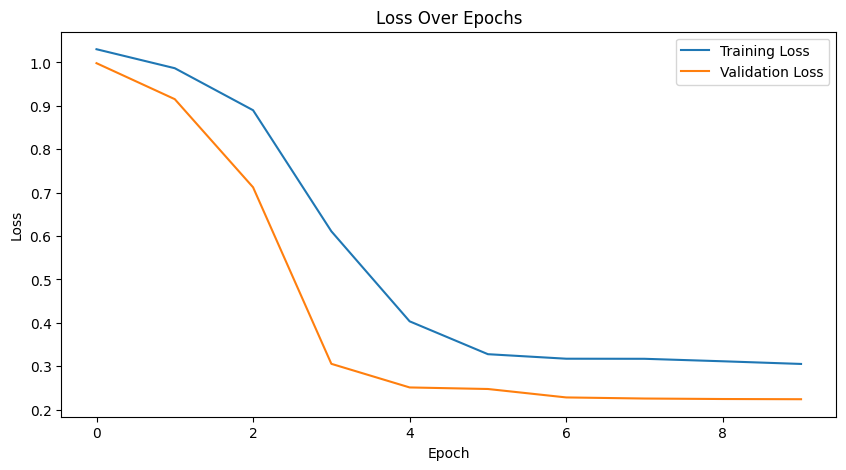

Generating predictions...


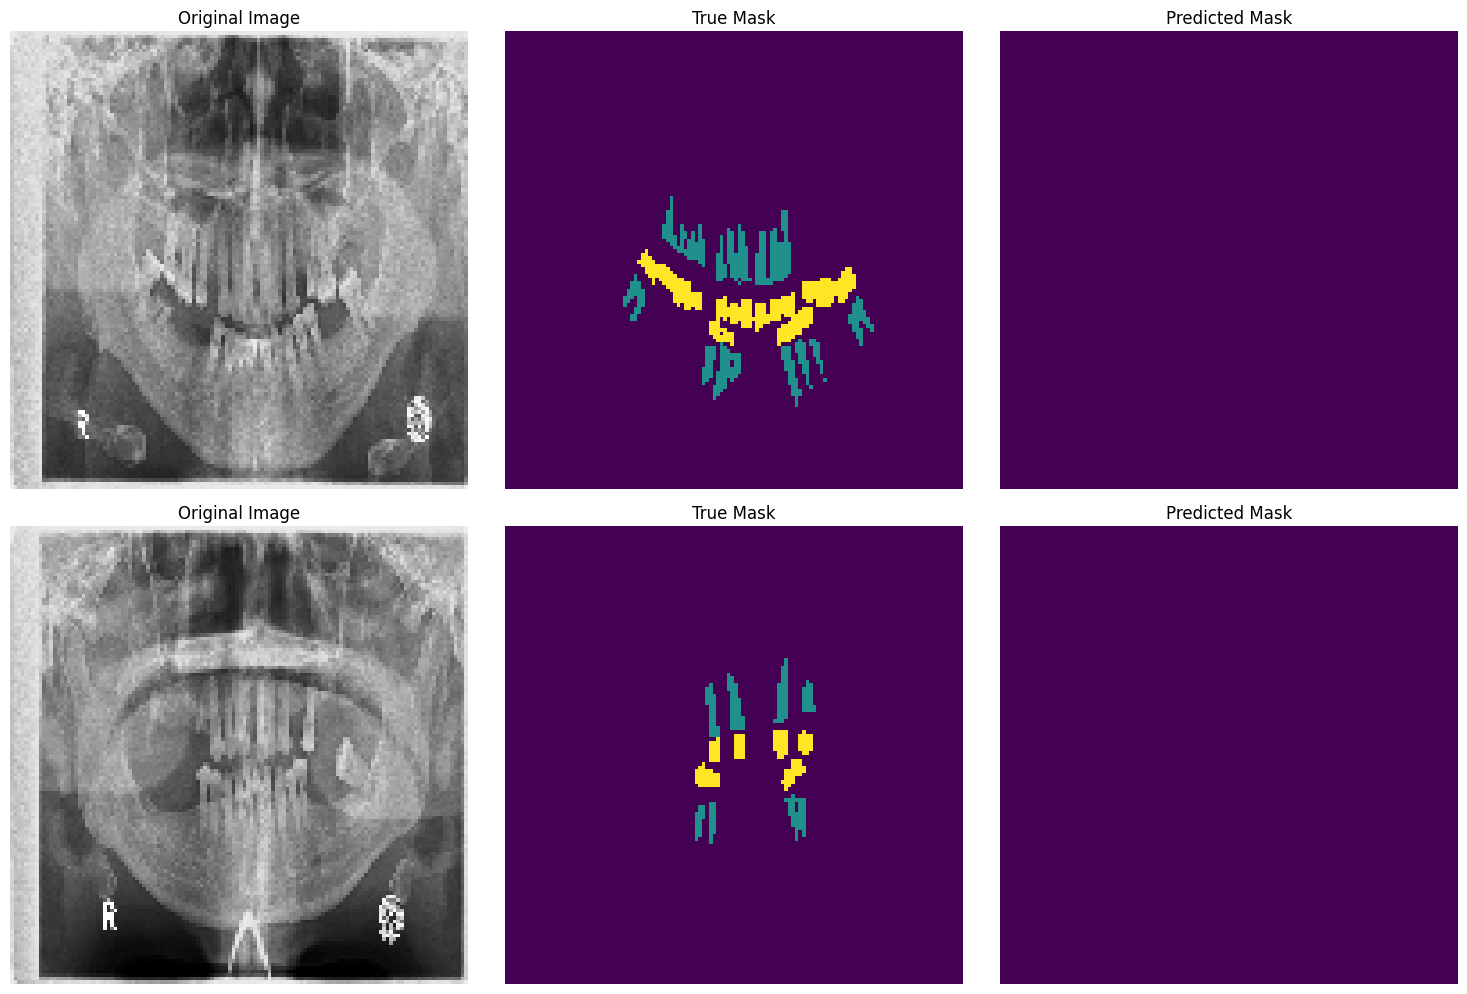

Training and evaluation complete!

To measure bone loss on a new image, use:
model.load_state_dict(torch.load('path/to/model.pth'))
mask = predict_on_new_image(model, 'path/to/your/image.jpg', device)
measure_bone_loss(mask)


In [25]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
IMAGE_DIR = "../data/cej_alveolar/train"
MASK_DIR = "../data/cej_alveolar/cej_alveolar_masked"  # Directory where your masks are saved
MODEL_OUTPUT_DIR = "../models"
BATCH_SIZE = 4
EPOCHS = 10
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 3  # Background (0), alveolar (128), and cej (255)
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Ensure model output directory exists
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# --- DATASET CLASS ---
class DentalSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalize to [0,1]
        img = np.transpose(img, (2, 0, 1))  # Convert to CxHxW format
        
        # Load mask
        mask_path = self.mask_paths[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # Convert grayscale values to class indices
        # 0 = background, 1 = alveolar (128), 2 = cej (255)
        mask_classes = np.zeros_like(mask)
        mask_classes[mask == 128] = 1  # alveolar
        mask_classes[mask == 255] = 2  # cej
        
        # Convert to tensors
        img_tensor = torch.FloatTensor(img)
        mask_tensor = torch.LongTensor(mask_classes)
        
        return img_tensor, mask_tensor

# --- PREPARE DATA PATHS ---
def prepare_data_paths():
    image_paths = []
    mask_paths = []
    
    # Get all image files
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in image_files:
        img_path = os.path.join(IMAGE_DIR, img_file)
        
        # Construct mask filename
        mask_filename = f"{os.path.splitext(img_file)[0]}_combined_mask.png"
        mask_path = os.path.join(MASK_DIR, mask_filename)
        
        # Check if mask exists
        if not os.path.exists(mask_path):
            print(f"Mask not found for {img_file}, skipping...")
            continue
        
        # Check if files can be opened
        try:
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None or mask is None:
                print(f"Failed to load image or mask: {img_file}")
                continue
                
            image_paths.append(img_path)
            mask_paths.append(mask_path)
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
    
    print(f"Found {len(image_paths)} valid image-mask pairs.")
    return image_paths, mask_paths

# --- U-NET MODEL DEFINITION ---
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super(UNet, self).__init__()
        # Encoder (downsampling)
        self.inc = self._double_conv(n_channels, 32)
        self.down1 = self._down(32, 64)
        self.down2 = self._down(64, 128)
        self.down3 = self._down(128, 256)
        
        # Decoder (upsampling)
        self.up1 = self._up(256, 128)
        self.up2 = self._up(128, 64)
        self.up3 = self._up(64, 32)
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Decoder path with skip connections
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.outc(x)
        return x
    
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def _down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self._double_conv(in_channels, out_channels)
        )
    
    def _up(self, in_channels, out_channels):
        return _UpBlock(in_channels, out_channels)

class _UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Calculate padding to match dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                              diffY // 2, diffY - diffY // 2])
        
        # Concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# --- TRAINING FUNCTION ---
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=EPOCHS):
    # For storing metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                val_loss = criterion(outputs, masks)
                
                running_val_loss += val_loss.item() * images.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIR, 'cej_alveolar_unet_best.pth'))
            print(f'Saved model at epoch {epoch+1} with validation loss: {best_val_loss:.4f}')
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIR, 'cej_alveolar_unet_final.pth'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(MODEL_OUTPUT_DIR, 'training_history.png'))
    plt.show()
    
    return model, train_losses, val_losses

# --- PREDICTION & VISUALIZATION ---
def predict_and_visualize(model, val_dataset, device, num_samples=3):
    model.eval()
    
    # Select random samples
    indices = np.random.choice(len(val_dataset), min(num_samples, len(val_dataset)), replace=False)
    
    plt.figure(figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get sample
            img, true_mask = val_dataset[idx]
            
            # Add batch dimension
            img = img.unsqueeze(0).to(device)
            
            # Make prediction
            outputs = model(img)
            pred_mask = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()
            
            # Convert tensors to numpy arrays for visualization
            img = img.squeeze().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))  # Convert from CxHxW to HxWxC
            true_mask = true_mask.cpu().numpy()
            
            # Plot original image
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')
            
            # Plot true mask (colormap to distinguish classes)
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(true_mask, cmap='viridis')
            plt.title('True Mask')
            plt.axis('off')
            
            # Plot predicted mask (same colormap)
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow(pred_mask, cmap='viridis')
            plt.title('Predicted Mask')
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_OUTPUT_DIR, 'predictions.png'))
    plt.show()

# --- INFERENCE ON NEW IMAGES ---
def predict_on_new_image(model, image_path, device):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    # Preserve original dimensions for later
    original_height, original_width = img.shape[:2]
    
    # Resize for prediction
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_normalized = img_resized / 255.0
    
    # Convert to tensor and add batch dimension
    img_tensor = torch.FloatTensor(np.transpose(img_normalized, (2, 0, 1))).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        pred_mask = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()
    
    # Convert back to original class values
    output_mask = np.zeros_like(pred_mask, dtype=np.uint8)
    output_mask[pred_mask == 1] = 128  # alveolar
    output_mask[pred_mask == 2] = 255  # cej
    
    # Resize back to original dimensions
    output_mask_resized = cv2.resize(output_mask, (original_width, original_height), 
                                     interpolation=cv2.INTER_NEAREST)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(output_mask_resized, cmap='viridis')
    plt.title('Predicted Segmentation')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return output_mask_resized

# --- BONE LOSS MEASUREMENT ---
def measure_bone_loss(mask):
    """
    Measure the distance between CEJ and alveolar bone crest for bone loss assessment
    """
    # Get coordinates of CEJ pixels (value 255)
    cej_coords = np.where(mask == 255)
    
    # Get coordinates of alveolar bone crest pixels (value 128)
    alveolar_coords = np.where(mask == 128)
    
    if len(cej_coords[0]) == 0 or len(alveolar_coords[0]) == 0:
        print("Could not find either CEJ or alveolar bone crest in the mask")
        return None
    
    # Find the lowest point (max y) of CEJ
    cej_lowest_y = np.max(cej_coords[0])
    cej_lowest_x = cej_coords[1][np.argmax(cej_coords[0])]
    
    # Find the highest point (min y) of alveolar bone crest near the same x-coordinate
    # Consider points within a certain range of the CEJ x-coordinate
    tolerance = 20  # Pixels
    nearby_alveolar = [(y, x) for y, x in zip(alveolar_coords[0], alveolar_coords[1]) 
                       if abs(x - cej_lowest_x) < tolerance]
    
    if not nearby_alveolar:
        print("No alveolar bone crest found near the CEJ")
        return None
    
    # Find the highest point (min y) of nearby alveolar points
    alveolar_highest_y = min([y for y, _ in nearby_alveolar])
    alveolar_highest_x = [x for y, x in nearby_alveolar if y == alveolar_highest_y][0]
    
    # Calculate Euclidean distance
    distance = np.sqrt((cej_lowest_y - alveolar_highest_y)**2 + 
                       (cej_lowest_x - alveolar_highest_x)**2)
    
    # Visualize the measurement
    vis_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    vis_mask[mask == 255] = [255, 0, 0]  # CEJ in red
    vis_mask[mask == 128] = [0, 255, 0]  # Alveolar in green
    
    # Draw the measurement line
    cv2.line(vis_mask, (cej_lowest_x, cej_lowest_y), 
             (alveolar_highest_x, alveolar_highest_y), (0, 0, 255), 2)
    
    # Add text with measurement
    cv2.putText(vis_mask, f"Distance: {distance:.2f} pixels", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_mask)
    plt.title('Bone Loss Measurement')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return distance

# --- MAIN EXECUTION ---
def main():
    # Check if CUDA is available, otherwise use CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    image_paths, mask_paths = prepare_data_paths()
    
    if len(image_paths) == 0:
        print("No valid data found. Please check paths and file formats.")
        return
    
    # Split data into train and validation sets
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=SEED)
    
    # Create datasets
    train_dataset = DentalSegmentationDataset(train_img_paths, train_mask_paths)
    val_dataset = DentalSegmentationDataset(val_img_paths, val_mask_paths)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Training on {len(train_dataset)} samples")
    print(f"Validating on {len(val_dataset)} samples")
    
    # Initialize model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    print("Starting training...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, device)
    
    # Visualize some predictions
    print("Generating predictions...")
    predict_and_visualize(model, val_dataset, device)
    
    print("Training and evaluation complete!")
    
    # Example of using the model for bone loss measurement
    print("\nTo measure bone loss on a new image, use:")
    print("model.load_state_dict(torch.load('path/to/model.pth'))")
    print("mask = predict_on_new_image(model, 'path/to/your/image.jpg', device)")
    print("measure_bone_loss(mask)")

if __name__ == "__main__":
    main()

In [1]:
pip install --upgrade protobuf tensorflow

  Using cached protobuf-6.30.2-cp39-cp39-win_amd64.whl (431 kB)
  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
Note: you may need to restart the kernel to use updated packages.
